# Comments

In [79]:
# When the entire notebook is ran, it
# should roughly take less than about
# 30 s to 45 s.

# Import appropriate packages and set analysis options.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from IPython.core.interactiveshell import InteractiveShell
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Setting save_predicted_data to True
# will cause the notebook to save data
# in one of the last commands to the
# path specified by MY_PREDICTED_DATA_PATH.
save_predicted_data = False

# As expected, setting print_all_output
# to True will cause each evaluation in a
# a cell to be displayed. This has the
# unfortunate side-effect of preventing the
# ';' operator from silencing output.
# If this boolean is set to False, then
# only the last item in each cell may
# be output.
print_all_output = False
InteractiveShell.ast_node_interactivity = 'all' if print_all_output else 'last_expr'

# Setting engineer_features to True will
# enable the creation of new data/features
# from the original housing data. This makes
# it simpler to include/exclude this extra
# data and determine whether it helps
# improve the models. Note: if this is
# set to true, then these same engineered
# features must be provided/added to the
# test data so that the prediction model has
# the same number of input features for both
# the training and testing data.
engineer_features = False

# Setting randomize_seeding to True will
# randomize various operations throughout
# the notebook. Setting it to False will
# cause the seed to remain fixed to some
# specified value such that the notebook
# can be reran with the same randomized
# variables (see MAGIC_SEED below).
randomize_seeding = False

# Define convenient variables and functions.

In [81]:
# These paths indicate from where the training
# and test data will be loaded.
TRAINING_DATA_PATH = "./Data/train.csv"
TEST_DATA_PATH = "./Data/test.csv"
MY_PREDICTED_DATA_PATH = "./Data/my_predicted_house_prices.csv"

# The MAGIC_SEED optionally specifies a fixed
# random state/seed so that the notebook can be
# reran with the same randomized variables (see
# randomize_seeding above).
MAGIC_SEED = 1776
if (randomize_seeding):
    MAGIC_SEED = np.random.seed()

# The training data provided with this data
# set will be split into two subsets so that
# models can be trained on the first and tested
# on the second. TRAINING_DATA_TEST_SIZE
# indicates the proportion of the training
# data that will be used as test data for
# model evaluation and should be in the
# range [0.0, 1.0].
TRAINING_DATA_TEST_SIZE = 0.10

def load_data(path):
    """
    Load the file at 'path' into a Pandas
    DataFrame.
    """
    df = pd.read_csv(path, header=0, index_col='Id')
    print("Loaded data dimensions: ", df.shape[0], "rows, ", df.shape[1], "columns")
    return df

def print_nan(nan_cols_counts, col_type):
    """
    Print each element of the list which should contain
    a DataFrame feature name and an int number of times
    the feature contains an NaN value.
    """
    print("\n", len(nan_cols_counts), " ", col_type, "-type columns with NaN values.", sep='')
    if(len(nan_cols_counts) > 0):
        print("    {:<16}{}".format("Feature", "NaN Count"))
        print("%s" % "    ---------------------")
    for index, element in enumerate(nan_cols_counts):
        print("{:>2}. {:<16}{}".format(index+1, element[0], element[1]))
        
def gather_nan(df, col_type, print_if_nan = True):
    """
    Find all DataFrame columns of type 'col_type'
    which contain NaN values.
    """
    if (col_type == "int"):
        columns = df.select_dtypes(include=['int']).columns
    elif (col_type == "float"):
        columns = df.select_dtypes(include=['float']).columns
    else:
        columns = df.select_dtypes(include=['object']).columns
    nan_cols_counts = []
    for col in np.sort(columns):
        num_nan = np.sum(df[col].isnull())
        if (num_nan > 0):
            nan_cols_counts.append((col, num_nan))
    if (print_nan):
        print_nan(nan_cols_counts, col_type)
    return nan_cols_counts
            
def replace_with_normal(df, col, seed = np.random.seed()):
    """
    Replace NaN values in a DataFrame column with
    values chosen from a normal distribution with
    a mean and standard deviation equal to the
    that of the non-NaN data.
    """
    np.random.seed(seed)
    df_dropped = df[col].dropna()
    mu = np.mean(df_dropped)
    sigma = np.std(df_dropped)
    null_rows = df[col].isnull()
    num_nan = np.sum(null_rows)
    rand_vals = np.random.normal(mu, sigma, num_nan)
    df.loc[null_rows, col] = rand_vals
    
def most_common_label(df, col):
    """
    Determine the most fequent label for
    categorical data.
    """
    most_common_appearances = 0
    most_common_label = ""
    for label in df[col].unique():
        num_appearances = np.sum(x_train[col] == label)
        if (num_appearances > most_common_appearances):
            most_common_appearances = num_appearances
            most_common_label = label
    return most_common_label

def evaluate_model(x_train, y_train, model):
    """
    Given an input model and training data,
    split the data into training/testing subsets
    and use this to produce a fit and predictions.
    Indicate the goodness of the fit and plot
    the results.
    """
    # Split the training data into two subsets.
    # Then, train the model on the target data
    # and use it to predict home prices.
    x_train1, x_train2, y_train1, y_train2 = train_test_split(
        x_train, y_train,
        test_size=TRAINING_DATA_TEST_SIZE,
        random_state=MAGIC_SEED)
    model.fit(x_train1, y_train1)
    y_train2_pred = model.predict(x_train2)
    
    # Evaluate the model & predictions by viewing
    # the cross-validation score, error, and
    # variance (where a variance of 1 indicates
    # a perfect prediction) and plotting the results.
    print(cross_val_score(model, x_train1, y_train1, cv=5))
    print("RMS Error: %.3f"
        % sqrt(mean_squared_error(y_train2, y_train2_pred)))
    print('Variance score: %.3f' % r2_score(y_train2, y_train2_pred))
    plt.scatter(y_train2, y_train2_pred, color='red', marker='x')
    plt.scatter(y_train2, y_train2, color='black', marker='.')
    plt.xlabel("True House Price")
    plt.ylabel("House Price")
    plt.legend(("Predicted Value", "True Value"))
    plt.show()
    
def most_important_features(df, feature_importances, num_features):
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1].tolist()
    top_n_indices = sorted_indices[:5]
    print("The %d most important features for this model:" % num_features)
    for ii, index in enumerate(top_n_indices):
        print("%d. %s" % (ii+1, x_train.columns[index]))

# Load and preview the housing training data.

In [82]:
df = load_data(TRAINING_DATA_PATH)
df.head()

Loaded data dimensions:  1460 rows,  80 columns


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [83]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Clean and process the training data.

In [84]:
# Partition data into features (X-data) and
# targets (Y-data).
x_train = df.iloc[:,:79]
y_train = df.iloc[:,79]

# Determine which features have missing values.
nan_int_cols = gather_nan(x_train, "int")
nan_float_cols = gather_nan(x_train, "float")
nan_string_cols = gather_nan(x_train, "string")


0 int-type columns with NaN values.

3 float-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. GarageYrBlt     81
 2. LotFrontage     259
 3. MasVnrArea      8

16 string-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Alley           1369
 2. BsmtCond        37
 3. BsmtExposure    38
 4. BsmtFinType1    37
 5. BsmtFinType2    38
 6. BsmtQual        37
 7. Electrical      1
 8. Fence           1179
 9. FireplaceQu     690
10. GarageCond      81
11. GarageFinish    81
12. GarageQual      81
13. GarageType      81
14. MasVnrType      8
15. MiscFeature     1406
16. PoolQC          1453


In [85]:
# View distribution details for the float-type
# features which have missing values. This will
# provide some insight on how to handle their
# missing values.
for element in nan_float_cols:
    print("\n", x_train[element[0]].describe())


 count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

 count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

 count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64


In [86]:
# Since 'GarageYrBlt' and 'LotFrontage' have
# means which are similar to their medians,
# their distributions aren't very skewed. It's
# probably safe to replace NaNs with the
# medians, but the approach that will be taken
# is to replace missing items with values
# randomly selected from a normal distribution
# with the same mean and standard deviation as
# the non-NaN value data.
replace_with_normal(x_train, 'GarageYrBlt', MAGIC_SEED)
replace_with_normal(x_train, 'LotFrontage', MAGIC_SEED)

# There are very few 'MasVnrArea' items with NaN values,
# but since the mean and median are very different,
# a normal distribution doesn't describe this data
# set very well. In this case, just replace NaNs
# with the median.
x_train.loc[:,'MasVnrArea'] = preprocessing.Imputer(strategy='median').fit_transform(df['MasVnrArea'].values.reshape(-1,1))

In [87]:
# According to data_description.txt,
# NaNs for the 16 categorical features
# shown (except 'Electrical') indicate
# "None". Therefore, find the most common
# 'Electrical' label and replace its
# single NaN value with this common label.
# Then, convert all remaining categorical NaNs
# to None so that label encoding can convert
# the remaining categorical data to ints.
x_train.loc[x_train['Electrical'].isnull() , 'Electrical'] = most_common_label(x_train, 'Electrical')
for col in x_train.select_dtypes(include=['object']).columns:
    x_train.loc[x_train[col].isnull(), col] = 'None'
le = preprocessing.LabelEncoder()
for col in x_train.select_dtypes(include=['object']).columns:
    le.fit(x_train[col].unique());
    x_train.loc[:, col] = le.transform(x_train[col]);

In [88]:
# At this point, the DataFrame should be free of
# missing values.
nan_int_cols = gather_nan(x_train, "int")
nan_float_cols = gather_nan(x_train, "float")
nan_string_cols = gather_nan(x_train, "string")
x_train.head()


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,2,2008,8,4
2,20,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,5,2007,8,4
3,60,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,9,2008,8,4
4,70,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,2,2006,8,0
5,60,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,12,2008,8,4


# Feature engineering: pick out or generate relevant metrics that may not be directly provided in the data.

In [89]:
# The following commented code can be used to
# see which features have "SF" ("square feet")
# in their labels. Note that there are other
# features whose units are square feet but
# which don't have "SF" in their labels.
### cols = x_train.columns.tolist()
### cols_with_SF = [s for s in cols if "SF" in s]

# Generally, the finished basement square feet
# and total enclosed square feet in the home can
# be important features. The notebook can be
# reevaluated with engineer_features set to true/false
# to determine whether these engineered features
# have a significant impact on model training/predictions.
if (engineer_features):
    x_train['BsmtFinSF'] = x_train['TotalBsmtSF'] - x_train['BsmtUnfSF']
    x_train['EnclosedSF'] = x_train['TotalBsmtSF'] + x_train['1stFlrSF'] + x_train['2ndFlrSF']

# Evaluate and compare various models.

## Method #1: Ordinary Least Squares

[ 0.56144024  0.83247115  0.86726124  0.67657475  0.84535629]
RMS Error: 27577.190
Variance score: 0.879


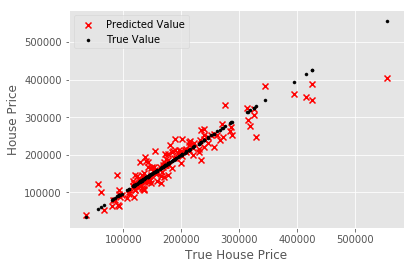

In [90]:
# Create and evaluate the model on the training data.
model = linear_model.LinearRegression()
evaluate_model(x_train, y_train, model)

## Method #2: Ridge Regression w/ Cross-Validation

[ 0.73967866  0.84756115  0.8644258   0.70559702  0.86440469]
RMS Error: 27450.526
Variance score: 0.880


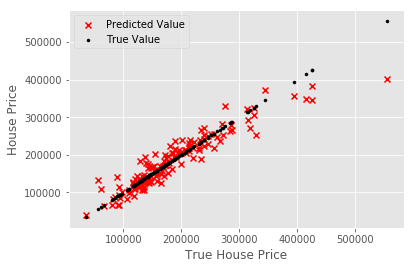

In [91]:
# Create and evaluate the model on the training data.
model = linear_model.RidgeCV(
    alphas=[0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0])
evaluate_model(x_train, y_train, model)

### Ridge regression tends to outperform ordinary least squares, but more sophisticated methods may provide even more accurate predictions.

## Method #3: Random Forest

[ 0.79623916  0.89183155  0.86239693  0.83532122  0.89602723]
RMS Error: 25511.464
Variance score: 0.896


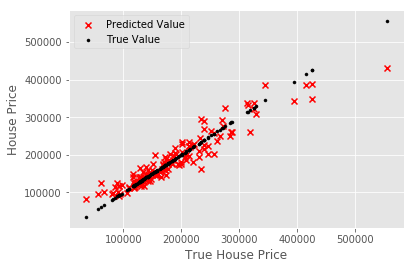

The 5 most important features for this model:
1. OverallQual
2. GrLivArea
3. 2ndFlrSF
4. TotalBsmtSF
5. BsmtFinSF1


In [92]:
# This cell should take about 10 s to evaluate.

# Create and evaluate the model on the training data.
# The hyperparameter were chosen by trial.
model = RandomForestRegressor(
    n_estimators=300, n_jobs=-1,
    random_state=MAGIC_SEED)
evaluate_model(x_train, y_train, model)

# List the most important features for this model.
most_important_features(x_train, model.feature_importances_, 5)

## Method #4: Gradient Boosting

[ 0.79123596  0.91540744  0.88083365  0.88221322  0.90679195]
RMS Error: 20830.453
Variance score: 0.931


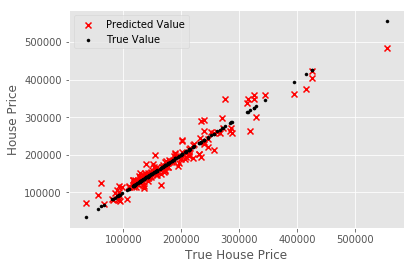

The 5 most important features for this model:
1. GrLivArea
2. OverallQual
3. TotalBsmtSF
4. LotArea
5. GarageArea


In [93]:
# This cell should take about 10 s to evaluate.

# Create and evaluate the model on the training data.
# The hyperparameter were chosen by trial.
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.075, subsample=0.90, random_state=MAGIC_SEED)
evaluate_model(x_train, y_train, model)

# List the most important features for this model.
most_important_features(x_train, model.feature_importances_, 5)

# Save the model for later usage.
prediction_model = model

### Gradient boosting fairly consistently outperforms random forest and outperforms ordinary least squares and ridge regression by a wide margin. Use this model to make predictions for the housing test data.

# Load and preview the housing test data.

In [94]:
df = load_data(TEST_DATA_PATH)
df.head()

Loaded data dimensions:  1459 rows,  79 columns


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [95]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Clean and process the test data.

In [96]:
# Since the test data only includes features,
# it is exclusively X-data.
x_test = df

# Determine which features have missing values.
nan_int_cols = gather_nan(x_test, "int")
nan_float_cols = gather_nan(x_test, "float")
nan_string_cols = gather_nan(x_test, "string")


0 int-type columns with NaN values.

11 float-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. BsmtFinSF1      1
 2. BsmtFinSF2      1
 3. BsmtFullBath    2
 4. BsmtHalfBath    2
 5. BsmtUnfSF       1
 6. GarageArea      1
 7. GarageCars      1
 8. GarageYrBlt     78
 9. LotFrontage     227
10. MasVnrArea      15
11. TotalBsmtSF     1

22 string-type columns with NaN values.
    Feature         NaN Count
    ---------------------
 1. Alley           1352
 2. BsmtCond        45
 3. BsmtExposure    44
 4. BsmtFinType1    42
 5. BsmtFinType2    42
 6. BsmtQual        44
 7. Exterior1st     1
 8. Exterior2nd     1
 9. Fence           1169
10. FireplaceQu     730
11. Functional      2
12. GarageCond      78
13. GarageFinish    78
14. GarageQual      78
15. GarageType      76
16. KitchenQual     1
17. MSZoning        4
18. MasVnrType      16
19. MiscFeature     1408
20. PoolQC          1456
21. SaleType        1
22. Utilities       2


In [97]:
# View distribution details for the float-type
# features which have missing values. This will
# provide some insight on how to handle their
# missing values.
for element in nan_float_cols:
    print("\n", x_test[element[0]].describe())


 count    1458.000000
mean      439.203704
std       455.268042
min         0.000000
25%         0.000000
50%       350.500000
75%       753.500000
max      4010.000000
Name: BsmtFinSF1, dtype: float64

 count    1458.000000
mean       52.619342
std       176.753926
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64

 count    1457.000000
mean        0.434454
std         0.530648
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

 count    1457.000000
mean        0.065202
std         0.252468
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

 count    1458.000000
mean      554.294925
std       437.260486
min         0.000000
25%       219.250000
50%       460.000000
75%       797.750000
max      2140.000000
Name: BsmtUnfS

In [98]:
# Since there are many NaNs in 'GarageYrBlt'
# and 'LotFrontage' and since they have
# means which are similar to their medians,
# their distributions aren't very skewed. It's
# probably safe to replace NaNs with the
# medians, but the approach that will be taken
# is to replace missing items with values
# randomly selected from a normal distribution
# with the same mean and standard deviation as
# the non-NaN value data.
replace_with_normal(x_test, 'GarageYrBlt', MAGIC_SEED)
replace_with_normal(x_test, 'LotFrontage', MAGIC_SEED)

# The mean and median of 'MasVnrArea' are quite
# different, so a normal distribution won't
# describe this data well. Just replace the NaNs
# with the median.
x_test.loc[:,'MasVnrArea'] = preprocessing.Imputer(strategy='median').fit_transform(df['MasVnrArea'].values.reshape(-1,1))

# Since 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
# 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea',
# 'GarageCars', and 'TotalBsmtSF' have very few
# items with NaN values and since data_description.txt
# dictates that many related features of these features can
# have NaN values to indicate "None", just replace the NaNs
# with 0.0. Note: this is done explicitly (rather than
# in a for-loop) so that the features under operation
# are made explicit.
x_test.loc[x_test['BsmtFinSF1'].isnull(), 'BsmtFinSF1'] = 0.0
x_test.loc[x_test['BsmtFinSF2'].isnull(), 'BsmtFinSF2'] = 0.0
x_test.loc[x_test['BsmtFullBath'].isnull(), 'BsmtFullBath'] = 0.0
x_test.loc[x_test['BsmtHalfBath'].isnull(), 'BsmtHalfBath'] = 0.0
x_test.loc[x_test['BsmtUnfSF'].isnull(), 'BsmtUnfSF'] = 0.0
x_test.loc[x_test['GarageArea'].isnull(), 'GarageArea'] = 0.0
x_test.loc[x_test['GarageCars'].isnull(), 'GarageCars'] = 0.0
x_test.loc[x_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = 0.0

In [99]:
# According to data_description.txt,
# 'Exterior1st', 'Exterior2nd', 'Functional',
# 'KitchenQual', 'MSZoning', 'SaleType', and
# 'Utilities' do not have a "None" type.
# Therefore, just set NaNs for these features
# to the most common label for each feature.
# Note: this is done explicitly (rather than
# in a for-loop) so that the features under
# operation are made explicit.
x_train.loc[x_train['Exterior1st'].isnull() , 'Exterior1st'] = most_common_label(x_train, 'Exterior1st')
x_train.loc[x_train['Exterior2nd'].isnull() , 'Exterior2nd'] = most_common_label(x_train, 'Exterior2nd')
x_train.loc[x_train['Functional'].isnull() , 'Functional'] = most_common_label(x_train, 'Functional')
x_train.loc[x_train['KitchenQual'].isnull() , 'KitchenQual'] = most_common_label(x_train, 'KitchenQual')
x_train.loc[x_train['MSZoning'].isnull() , 'MSZoning'] = most_common_label(x_train, 'MSZoning')
x_train.loc[x_train['SaleType'].isnull() , 'SaleType'] = most_common_label(x_train, 'SaleType')
x_train.loc[x_train['Utilities'].isnull() , 'Utilities'] = most_common_label(x_train, 'Utilities')

In [100]:
# Convert all remaining categorical NaNs to None
# so that label encoding can convert the
# remaining categorical data to ints.
for col in x_test.select_dtypes(include=['object']).columns:
    x_test.loc[x_test[col].isnull(), col] = 'None'
le = preprocessing.LabelEncoder()
for col in x_test.select_dtypes(include=['object']).columns:
    le.fit(x_test[col].unique());
    x_test.loc[:, col] = le.transform(x_test[col]);

In [101]:
# At this point, the DataFrame should be free of
# missing values.
nan_int_cols = gather_nan(x_test, "int")
nan_float_cols = gather_nan(x_test, "float")
nan_string_cols = gather_nan(x_test, "string")
x_test.head()


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,3,80.0,11622,1,1,3,3,0,4,...,120,0,2,2,1,0,6,2010,9,4
1462,20,4,81.0,14267,1,1,0,3,0,0,...,0,0,2,4,0,12500,6,2010,9,4
1463,60,4,74.0,13830,1,1,0,3,0,4,...,0,0,2,2,1,0,3,2010,9,4
1464,60,4,78.0,9978,1,1,0,3,0,4,...,0,0,2,4,1,0,6,2010,9,4
1465,120,4,43.0,5005,1,1,0,1,0,4,...,144,0,2,4,1,0,1,2010,9,4


# Use prediction_model to predict y_test.

In [102]:
# Generate the predicted house prices.
y_test_pred = prediction_model.predict(x_test)

# List the most important features for this model.
most_important_features(x_test, model.feature_importances_, 5)

The 5 most important features for this model:
1. GrLivArea
2. OverallQual
3. TotalBsmtSF
4. LotArea
5. GarageArea


In [103]:
# Convert y_test_pred to a DataFrame
# with indices and a column label consistent
# with the submission criteria as demonstrated
# in sample_submission.csv.
y_test_pred_df = pd.DataFrame(y_test_pred, index=x_test.index, columns=['SalePrice'])

# Ensure the DataFrame appears to be
# properly arranged.
y_test_pred_df.head()

,SalePrice
Id,
1461,126640.630529
1462,156009.389089
1463,179093.983196
1464,184689.720408
1465,189905.404534


In [104]:
# Write the DataFrame to a .csv file.
if (save_predicted_data):
    y_test_pred_df.to_csv(MY_PREDICTED_DATA_PATH)